In [2]:
import numpy as np
import graphinglib as gl
from copy import deepcopy
from astropy.convolution import convolve, Gaussian2DKernel

from src.hdu.grouped_maps import GroupedMaps
from src.hdu.map import Map
from src.coordinates.fits_coords import FitsCoords

In [3]:
gm = GroupedMaps.load_from_loki(
    "data/loki/output_NGC4696_G235H_F170LP_full_OQBr_tied/NGC4696_G235H_F170LP_full_OQBr_tied_parameter_maps.fits"
)

invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.wcs.wcs]
invalid keyvalue. [astropy.w

In [4]:
SNR_cut = 3
arrows = [
    gl.Arrow((7.8+20, 2-23), (12.8+20, 7-23), "black"),
    gl.Arrow((8.2+20, 2-23), (3.2+20, 7-23), "black"),
    gl.Text(13+20, 7-23, "N", color="black", font_size=15, h_align="center", v_align="bottom"),
    gl.Text(3+20, 7-23, "E", color="black", font_size=15, h_align="center", v_align="bottom"),
]
AGN_pos = gl.Point(40.1257819, -3.16990997, marker_style="x", face_color="red", marker_size=50)

In [ ]:
# CONTOURS

flux = Map.load("test_flux.fits")

hm_orig = flux.data.plot
hm_orig.show_color_bar = False

hm_rot = flux.rotate_field()
# hm_rot.color_map = "plasma"
hm_rot.show_color_bar = False

theta = -47 * np.pi/180
point_orig = gl.Point(3, 27, color="crimson", marker_style="8", marker_size=50)
point_rot = point_orig.copy()
# Add 0.5 to convert from pixel center to pcolormesh edge-based coordinates
x_center = point_orig.x + 0.5
y_center = point_orig.y + 0.5
point_rot.x = np.cos(theta) * x_center - np.sin(theta) * y_center
point_rot.y = np.sin(theta) * x_center + np.cos(theta) * y_center

cont_data = np.zeros_like(flux.data)
cont_data[35:40, 30:40] = 1
cont_data[25:35, 33:37] = 1
cont_data[30:39, 34:36] = 2
cont_orig = gl.Contour(*np.mgrid[:flux.shape[0], :flux.shape[1]][::-1], cont_data, 1, filled=False)
cont_orig.show_color_bar = False

cont_rot = cont_orig.copy()
x_mesh_edges, y_mesh_edges = cont_orig.x_mesh + 0.5, cont_orig.y_mesh + 0.5
cont_rot.x_mesh = np.cos(theta) * x_mesh_edges - np.sin(theta) * y_mesh_edges
cont_rot.y_mesh = np.sin(theta) * x_mesh_edges + np.cos(theta) * y_mesh_edges

gl.SmartFigure(1, 2, aspect_ratio="auto", size=(13, 7),
               elements=[[hm_orig, point_orig, cont_orig],
                         gl.SmartFigure(elements=[hm_rot, point_rot, cont_rot], x_lim=(20, 61), y_lim=(-22, 20))]).show()


# Introduction

## Pretty Figure

In [ ]:
data = fits.open(
    "data/output_NGC4696_G235H_F170LP_full_model/NGC4696_G235H_F170LP_full_model_parameter_maps.fits"
)[67].data  # H_2(1-0)
hm = gl.Heatmap(data, origin_position="lower", show_color_bar=False, color_map_range=(-18, -16))
zoomed_hm = gl.Heatmap(data[24:33,24:33], origin_position="lower", show_color_bar=False, color_map_range=(-18, -16))
zoomed_hm_2 = zoomed_hm.copy()
zoomed_hm_2.image = zoomed_hm.image[2:7,2:7]
zoomed_hm_2.color_map = "plasma"

fig = gl.SmartFigure(
    2,
    2,
    remove_x_ticks=True,
    remove_y_ticks=True,
    size=(11, 6),
    width_ratios=[5, 2],
    reference_labels=False,
    width_padding=0,
    height_padding=0,
).set_visual_params(use_latex=True)
fig[:, 0] = [
    hm,
    gl.Text(1, 54, "NGC 4696 ($z=0.0104$)", h_align="left"),
    gl.Text(1, 52, "Central dominant galaxy in the Centaurus Cluster", h_align="left"),
    gl.Text(1, 3, r"H$\alpha$ HST ...", h_align="left"),
    gl.Text(1, 1, r"Chandra X-ray (blue) ...", h_align="left"),
    gl.Text(28, 35, r"[Chandra X-ray + H$\alpha$ HST image"+"\nof the whole cluster]", font_size=20),
    gl.Line((45, 1), (55, 1), capped_line=True, cap_width=0.5, width=1),
    gl.Text(50, 2, "x kpc"),
    gl.Rectangle(23.5, 23.5, 9, 9, fill=False),
    gl.Polygon([[9+23.5, 23.5], [9+23.5, 9+23.5], [60, 60], [60, 28.7]], fill=False),
]
fig[0, 1] = [
    zoomed_hm,
    gl.Text(4, 3, "[Identify with\narrows the AGN\nand filaments]", font_size=15),
    gl.Text(6.5, 7.3, "x kpc"),
    gl.Line((5, 7), (8, 7), capped_line=True, cap_width=0.5, width=1),
    gl.Rectangle(1.5, 1.5, 5, 5, fill=False),
    gl.Polygon([[-0.5, -0.5], [1.5, 1.5], [6.5, 1.5], [9.5, -1.5]], fill=False),
]
fig[1, 1] = [
    zoomed_hm_2,
    gl.Rectangle(0.5, 0.5, 3, 3, fill=False),
    gl.Text(2, 4, "[MUSE velocity field]", font_size=15),
    gl.Text(2, 3.1, "[NIRSpec's FOV]", font_size=15),
    gl.Line((2, 0), (4, 0), capped_line=True, cap_width=0.5, width=1),
    gl.Text(3, 0.2, "x kpc"),
]
fig.show().save("figures/article/fig_1.pdf", dpi=600)

# Results

## Region spectra

/Users/mathieumarquis/Desktop/Maitrise/Recherche/master_centaurus/graphinglib/graphinglib/graph_elements.py:786: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes.scatter(


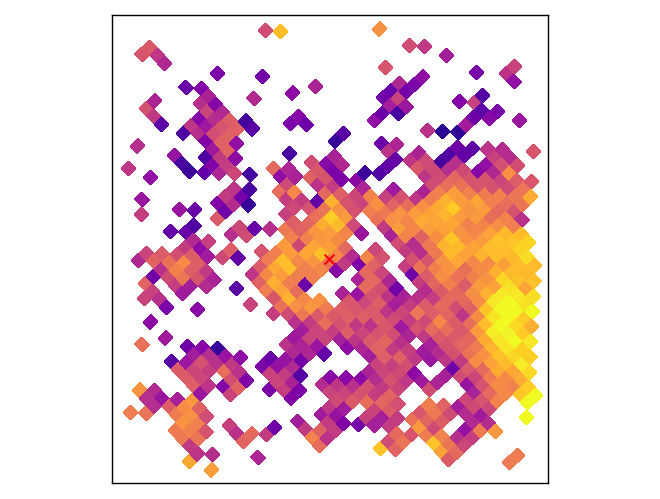

In [8]:
flux = gm["LINES.H210_S1.TOTAL_FLUX"]
snr = gm["LINES.H210_S1.TOTAL_SNR"]
flux = flux.mask(snr.data > 3)

hm_orig = flux.data.plot
hm_orig.show_color_bar = False

hm_rot = flux.rotate_field()
hm_rot.color_map = "plasma"
hm_rot.show_color_bar = False
hm_rot.color_map_range = -19, -17.5

gl.SmartFigure(
    aspect_ratio=1,
    remove_x_ticks=True,
    remove_y_ticks=True,
    x_lim=(20, 60.5),
    y_lim=(-24, 19.5),
    elements=[hm_rot, AGN_pos],
).show()

## Kinematics of the gas

In [ ]:
lines = [f"LINES.H210_{trans}.{p}" for trans in ["S3", "O3"] for p in ["1.FLUX", "1.VOFF", "1.FWHM"]]
hms = []

for i, line in enumerate(lines):
    map_ = gm[line]
    map_ = map_.mask(gm[f"{line[:14]}TOTAL_SNR"].data > SNR_cut)

    match i % 3:
        case 0:
            cmap_range = -18.2, -17.35
            cmap = "plasma"
        case 1:
            cmap_range = -250, 250
            cmap = "coolwarm"
        case 2:
            cmap = "viridis"
            cmap_range = 51, 240
            map_ /= 2 * np.sqrt(2 * np.log(2))  # FWHM to sigma

    hm = map_.rotate_field()
    hm.color_map = cmap
    hm.color_map_range = cmap_range
    if i > 2:
        hm.show_color_bar = False
    hms.append(hm)

hms[0].set_color_bar_params(position="top", label=r"\textbf{log($F$ [erg s$^{-1}$ cm$^{-2})$]}")
hms[1].set_color_bar_params(position="top", label=r"\textbf{velocity $v$ [km s$^{-1}$]}")
hms[2].set_color_bar_params(position="top", label=r"\textbf{vel. dispersion $\mathbf{\sigma}$ [km s$^{-1}$]}")

AGN_pos_white = gl.Point(40.3, 0, marker_style="x", color="white", marker_size=50)
white_arrows = deepcopy(arrows)
for arrow in white_arrows:
    arrow.color = "white"

texts = [gl.Text(58, 19, "H$_2$ 1-0 $S(3)$", h_align="right", v_align="top", color="black")]*3
texts += [gl.Text(58, 19, "H$_2$ 1-0 $O(3)$", h_align="right", v_align="top", color="black")]*3
text_boxes = [gl.Rectangle(43, 17, 14, 1, fill=False, line_width=10, edge_color="white")]*6

fig = gl.SmartFigure(
    2,
    3,
    # aspect_ratio=1,
    size=(6.4, 5.2),
    figure_style="dim",
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=[*list(zip(hms, text_boxes, texts, [AGN_pos_white]*6))],
    # elements=[*list(zip(hms, [AGN_pos]*6))],
    reference_labels_loc=(0.03, -0.16),
    width_padding=0,
    height_padding=0,
    height_ratios=[1.27, 1],
    x_lim=(20, 60),
    y_lim=(-23, 20),
).set_visual_params(use_latex=True, font_family="serif")#.show()
fig[1, 0] += white_arrows
fig.save("figures/meetings/january_2026/gas_kinematics.png", dpi=600, transparent=True)

## Kinematics of the stars

In [ ]:
lines = [f"LINES.H210_S1.{p}" for p in ["VPEAK", "1.FWHM"]]
lines += [f"CONTINUUM.STELLAR_{p}" for p in ["KINEMATICS.VEL", "KINEMATICS.VDISP"]]
hms = []

for i, line in enumerate(lines):
    map_ = gm[line]
    if i < 2:
        map_ = map_.mask(gm[f"{line[:14]}TOTAL_SNR"].data > SNR_cut)

    match i % 2:
        case 0: cmap = "coolwarm"
        case 1: cmap = "viridis"

    if i == 1:
        map_ /= 2 * np.sqrt(2 * np.log(2))  # FWHM to sigma

    hm = map_.rotate_field()
    hm.color_map = cmap
    hms.append(hm)

hms[0].set_color_bar_params(position="top", label=r"\textbf{velocity $v$ [km s$^{-1}$]}")
hms[1].set_color_bar_params(position="top", label=r"\textbf{vel. dispersion $\sigma$ [km s$^{-1}$]}")
hms[2].show_color_bar = False
hms[3].show_color_bar = False

hms[0].color_map_range = -65, 65
hms[2].color_map_range = -65, 65
hms[1].color_map_range = 87, 325
hms[3].color_map_range = 87, 325

texts = [gl.Text(58, 19, "H$_2$ 1-0 $S(1)$", h_align="right", v_align="top", color="black")]*2
texts += [gl.Text(58, 19, "Stars", h_align="right", v_align="top", color="black")]*2
text_boxes = [gl.Rectangle(45.5, 17.2, 11.5, 1, fill=False, line_width=10, edge_color="white")]*2
text_boxes += [gl.Rectangle(53, 17.5, 4, 1, fill=False, line_width=10, edge_color="white")]*2

fig = gl.SmartFigure(
    2,
    2,
    # aspect_ratio=1,
    size=(5, 6),
    figure_style="dim",
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=[*list(zip(hms, text_boxes, texts, [AGN_pos]*4))],
    reference_labels_loc=(0.03, -0.16),
    width_padding=0,
    height_padding=0,
    height_ratios=[1.24, 1],
    x_lim=(20, 60),
    y_lim=(-23, 20),
).set_visual_params(use_latex=True, font_family="serif")#.show()
fig[1, 0] += arrows
fig.save("figures/meetings/january_2026/stellar_kinematics.png", dpi=600, transparent=True)

## Approaching/receding components

In [ ]:
lines = [f"LINES.HI_PA_ALPHA.{i}.VOFF" for i in [1, 2]]

for i, line in enumerate(lines):
    map_ = gm[line]
    map_ = map_.mask(gm[f"{line[:20]}SNR"].data > SNR_cut)

    hm = map_.rotate_field()
    hm.color_map = "coolwarm"
    hms.append(hm)

hms[0].show_color_bar = False
hms[1].set_color_bar_params(position="right", label=r"\textbf{velocity $v$ [km s$^{-1}$]}")

hms[0].color_map_range = -800, 800
hms[1].color_map_range = -800, 800

texts = [gl.Text(58, 19, r"Pa$\alpha$", h_align="right", v_align="top", color="black")]*2
text_boxes = [gl.Rectangle(45.5, 17.2, 11.5, 1, fill=False, line_width=10, edge_color="white")]*2

fig = gl.SmartFigure(
    1,
    2,
    # aspect_ratio=1,
    size=(8, 5),
    figure_style="dim",
    remove_x_ticks=True,
    remove_y_ticks=True,
    # elements=[*list(zip(hms, text_boxes, texts, [AGN_pos]*2))],
    elements=[*list(zip(hms))],
    reference_labels_loc=(0.03, -0.16),
    width_padding=0,
    height_padding=0,
    x_lim=(20, 60),
    y_lim=(-23, 20),
).set_visual_params(use_latex=True, font_family="serif")#.show()
# fig[1, 0] += arrows
fig.save("figures/meetings/january_2026/approaching_receding_pa_alpha.png", dpi=600, transparent=True)

In [ ]:
stellar_velocity = gm["CONTINUUM.STELLAR_KINEMATICS.VEL"]

hm = gl.Heatmap(stellar_velocity.data, (1, 57), (1, 57), color_map_range=(-35, 15), show_color_bar=False, origin_position="lower")
# hm = stellar_velocity.data.plot
# hm.x_axis_range = 1, 57
# hm.y_axis_range = 1, 57
# hm.show_color_bar = False
# hm.color_map_range = -35, 15
# point = gl.Point(30.184042838533113, 27.684265720692814)
point = gl.Point(3, 29)

fig = gl.SmartFigure(
    # aspect_ratio=1,
    size=(6, 6),
    remove_x_ticks=True,
    remove_y_ticks=True,
    elements=[hm, point],
    # x_lim=(20, 60),
    # y_lim=(-23, 20),
).set_visual_params(use_latex=True, font_family="serif").show()
# fig.save("test_orig.png", dpi=600)

## P-V diagrams

/Users/mathieumarquis/Desktop/Maitrise/Recherche/master_centaurus/graphinglib/graphinglib/graph_elements.py:786: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes.scatter(


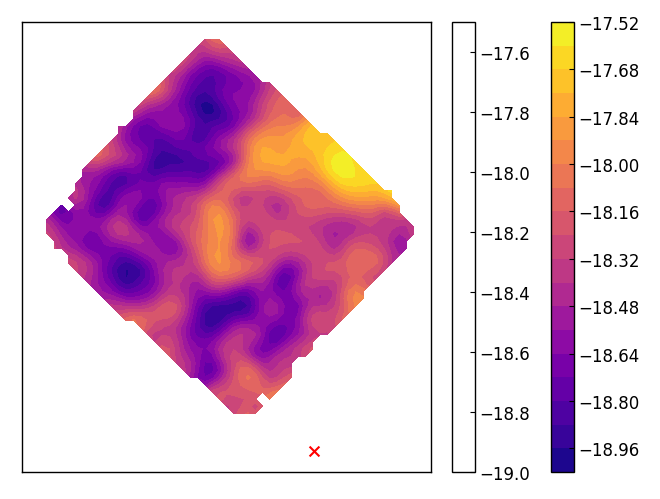

In [30]:
import cv2

flux = gm["LINES.H210_S1.TOTAL_FLUX"].copy()
snr = gm["LINES.H210_S1.TOTAL_SNR"].copy()
# flux = flux.mask(snr.data > 3)
inf_mask = np.isinf(flux.data)
flux.data[inf_mask] = np.nan

hm_rot = flux.data.plot#rotate_field()
hm_rot.color_map = "plasma"
# hm_rot.show_color_bar = False
hm_rot.color_map_range = -19, -17.5
smoothed_data = convolve(flux.data, Gaussian2DKernel(1.2), preserve_nan=True, boundary="extend")
smoothed_data = cv2.inpaint(smoothed_data.astype(np.float32), inf_mask.astype(np.uint8), inpaintRadius=1, flags=cv2.INPAINT_NS)

hm_smooth = gl.Heatmap(smoothed_data, origin_position="lower", color_map="plasma", show_color_bar=True)
cont = gl.Contour(*np.mgrid[:flux.shape[0], :flux.shape[1]][::-1], smoothed_data, number_of_levels=20, color_map="plasma")
hm_rot.alpha_value = 0

gl.SmartFigure(
    aspect_ratio=1,
    remove_x_ticks=True,
    remove_y_ticks=True,
    # x_lim=(20, 60.5),
    # y_lim=(-24, 19.5),
    elements=[cont, hm_rot, AGN_pos],
).show()